# Taming text
In this notebook, we analyse the content of Hillary Clinton's emails that went out during the email controversy of 2016. We will: 
* generate a word cloud based on the raw corpus
* perform a standard text preprocessing consisting in tokenization, stemming and/or lemmatization and stopwords removal
* perform a sentiment analysis to know what H.Clinton thinks of each country, using the library pycountry
* run topic modelling over the whole corpus, tuning the parameters

# Question 1: Word Cloud
## Part 1: Word Cloud on the raw corpus
First, let us import all the libraries that we will need in this notebook.

In [1]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pycountry
from nltk import wordpunct_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
%matplotlib inline

/home/ondine/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Read the whole text of the emails.

In [2]:
d = path.dirname('hillary-clinton-emails/')
text = open(path.join(d, 'Emails.csv')).read()

Generate and display a wordcloud with chosen max_font_size to be able to see more words.

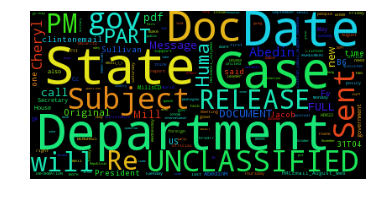

In [3]:
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can see that there is a lot of trash, including key words that are not part of the emails (like "Re" or "Unclassified" or "Release") together with words that give not any information about the content of the email (like "will", "document", "part", "pm", "new", etc.). We thus need to do 2 things:
* Choose the most relevant fields in "Emails.csv".
* Preprocess the data to get rid of the useless words and to keep only the relevant ones.

Now we thus perform the same actions, but without the full data in *Emails.csv*. We only take into account the *ExtractedBodyText* and *MetadataSubject*. We have chosen *MetadataSubject* and not *ExtractedSubject* since it appeared to be more a more accurate and a more complete field in order to retrieve the subject of the email.

So we first read all the data.

In [4]:
fullDF = pd.read_csv('hillary-clinton-emails/Emails.csv')

Then we extract the two columns we are interested in.

In [5]:
fullDF['ExtractedBodyText'].to_csv('hillary-clinton-emails/BodyText.csv',index=False)

In [6]:
fullDF[['ExtractedBodyText','MetadataSubject']].to_csv('hillary-clinton-emails/BodyEmails.csv',index=False)

And we finally perform all the actions in order to get the Word Cloud.

In [7]:
bodyDF = pd.read_csv('hillary-clinton-emails/BodyEmails.csv')
bodyCSV = open(path.join(d, 'BodyEmails.csv')).read()
bodyCSV = bodyCSV[35:] #Begin at index 35 to get rid of the header

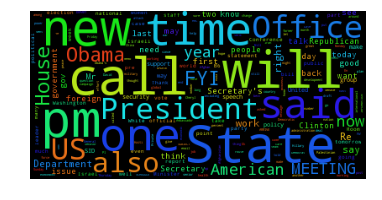

In [8]:
# Display wordcloud with a lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(bodyCSV)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This is already a little bit better, but still not fully satisfying. Indeed, we do not have anymore the words that are not part of what the writter of the email wrote (like "Unclassified") but we still have words that do not give any information about the content of the email (like "pm" or "now"). Moreover, we might lack some words because of the fact that the appear under different forms (for example "aid" should be the same word as "aiding" for our analysis). We will thus:
* perform first a tokenization to extract the words; we use wordpunct_tokenize in order to better consider the punctuation
* then compare the effect of stemming and lemmatizing, comparing LancasterStemmer and WordNetLemmatizer
* finally create a list of stopwords that we will remove from the list of words extracted from the emails.

## Part 2
### Tokenization

In [9]:
#tokens = nltk.word_tokenize(bodyCSV)
tokens = wordpunct_tokenize(bodyCSV)

In [10]:
print(tokens[0:30])
print(len(tokens))

['WOW', '"', 'B6', 'Thursday', ',', 'March', '3', ',', '2011', '9', ':', '45', 'PM', 'H', ':', 'Latest', 'How', 'Syria', 'is', 'aiding', 'Qaddafi', 'and', 'more', '...', 'Sid', 'hrc', 'memo', 'syria', 'aiding', 'libya']
794111


We can see that each word, and also each character of the punctuation, has been extracted and considered separately.

### Stemming
* First way: performing a LancasterStemmer, that is we stem every word that we have extracted by tokenization. 

In [11]:
st = LancasterStemmer()
stemmed_tokens = [st.stem(word) for word in tokens]

In [12]:
print(stemmed_tokens[0:30])
print('We have obtained ' + str(len(stemmed_tokens)) + ' stemmed tokens.')

['wow', '"', 'b6', 'thursday', ',', 'march', '3', ',', '2011', '9', ':', '45', 'pm', 'h', ':', 'latest', 'how', 'syr', 'is', 'aid', 'qaddaf', 'and', 'mor', '...', 'sid', 'hrc', 'memo', 'syr', 'aid', 'liby']
We have obtained 794111 stemmed tokens.


And we display the corresponding wordcloud.

In [13]:
stemmedBody = ' '.join(stemmed_tokens)

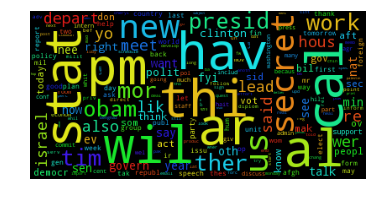

In [14]:
wordcloud = WordCloud(max_font_size=60).generate(stemmedBody)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We see that the stemmer cut words into their most trivial form. But very often, the trivial form does not give a word that is in the dictionary, and it is even hard for us to understand what some words mean (such as "ar" or "al"). Moreover, some words can have a very different meaning, but they are stemmed in the same way. For example, "secretary" and "secret" are both stemmed into "secret". 

We will thus use instead a lemmatizer.

* Second way: using WordNetLemmatizer. The option `pos = 'v'` is used so that the verbs go back to their infinitive form (ex: is -> be). Moreover, we do not forget to use the function `.lower()` to get rid of all the capital letters, and bring them back to their "small letters". In this way, words are considered the same even if the one that wrote the email forgot or added a capital letter.

In [15]:
lm = WordNetLemmatizer()
lemm_tokens2 = [lm.lemmatize(word.lower(),pos='v') for word in tokens]

In [16]:
print(lemm_tokens2[0:30])
print('We have obtained ' + str(len(lemm_tokens2)) + ' stemmed tokens.')

['wow', '"', 'b6', 'thursday', ',', 'march', '3', ',', '2011', '9', ':', '45', 'pm', 'h', ':', 'latest', 'how', 'syria', 'be', 'aid', 'qaddafi', 'and', 'more', '...', 'sid', 'hrc', 'memo', 'syria', 'aid', 'libya']
We have obtained 794111 stemmed tokens.


And we display the corresponding wordcloud.

In [17]:
lemmBody2 = ' '.join(lemm_tokens2)

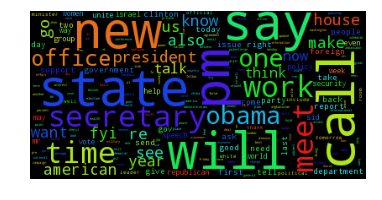

In [18]:
# Display wordcloud with a lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(lemmBody2)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This is already more satisfactory since words are recognizable, and "identical" words are considered the same. However, there are a lot of trash words such that "new", "also", "one", etc. We will thus need to remove some stop words, using the stopwords in `nltk.corpus` and adding some other ones.

### Stop words

We use the list of stopwords of `nltk.corpus` and we add some more, in the following cell.

In [19]:
stop = stopwords.words('english')
stop.append('also')
stop.append('new')
stop.append('one')
stop.append('two')
stop.append('pm')
stop.append('make')
stop.append('see')
stop.append('will')
stop.append('want')
stop.append('know')
stop.append('call')
stop.append('say')
stop.append('think')
stop.append('work')
stop.append('go')
stop.append('talk')
stop.append('need')
stop.append('meet')

Now we remove all the words that are in the stopwords list, and we turn all the words into lower cases.

In [20]:
filtered_tokens = [word.lower() for word in lemm_tokens2 if word.lower() not in stop]

In [21]:
print(filtered_tokens[0:30])
print(len(filtered_tokens))

['wow', '"', 'b6', 'thursday', ',', 'march', '3', ',', '2011', '9', ':', '45', 'h', ':', 'latest', 'syria', 'aid', 'qaddafi', '...', 'sid', 'hrc', 'memo', 'syria', 'aid', 'libya', '030311', '.', 'docx', ';', 'hrc']
502243


In [22]:
filteredBody = ' '.join(filtered_tokens)

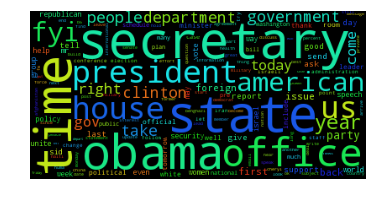

In [23]:
# Display wordcloud with a lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(filteredBody)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Question 2

### Part 1, country count
Our first goal is to count the number of occurences of each country name in the email corpus. We will use `pycountry` to help us to do so. In `pycountry`, not only we have the names of each country, but also the short names (ex: US or USA for United States of America), called alpha_2 or alpha_3. 
In order to find these short names of the countries, we suppose that they are always written in capital letters. This allow us to avoid the confusion between "us" and "US" for the United States, or between "it" and "IT" for Italy for example ;) ) This is why this step is done before stemming/lemmatizing, where all the capital letters will be changed to small characters.

We thus iterate in the `pycountry` list of countries and count the occurencies of the alpha_2 and alpha_3 entries in the corpus. We do not do it in the whole corpus, but just in the "ExtractedBodyText" since the "MetadataSubject" fields returns everything in capital letters, and it is thus not relevant. We thus have to be careful to redo the preprocessing step but without stemming/lemmatizing. 

Fist, read the data.

In [24]:
textCSV = open(path.join(d, 'BodyText.csv')).read()
textCSV = textCSV[4:] #Begin at index 4 to get rid of the header

Then, tokenize.

In [25]:
text_tokens = wordpunct_tokenize(textCSV)

Remove stop words. We have added three stop words because they arise often in the email but without meaning the actual country. This is to higher the accuracy of our results.

In [26]:
stop.append('na') #Namibia
stop.append('fm') #Micronesia, Federated States of
stop.append('ms') #Montserrat
filtered_text_tokens = [word for word in text_tokens if word.lower() not in stop]

Finally, let us count the occurencies of the short names of the countries.

In [27]:
occurencies = defaultdict(int)
for country in list(pycountry.countries):
    try:
        occurencies[country.name] += filtered_text_tokens.count(country.alpha_2)
    except:
        pass
    try: 
        occurencies[country.name] += filtered_text_tokens.count(country.alpha_3)
    except:
        pass

Here is the result:

In [28]:
occurencies

defaultdict(int,
            {'Afghanistan': 6,
             'Albania': 11,
             'Algeria': 0,
             'American Samoa': 0,
             'Andorra': 0,
             'Angola': 0,
             'Anguilla': 3,
             'Antarctica': 18,
             'Antigua and Barbuda': 0,
             'Argentina': 2,
             'Armenia': 0,
             'Aruba': 0,
             'Australia': 6,
             'Austria': 0,
             'Azerbaijan': 4,
             'Bahamas': 1,
             'Bahrain': 0,
             'Bangladesh': 0,
             'Barbados': 2,
             'Belarus': 0,
             'Belgium': 0,
             'Belize': 0,
             'Benin': 0,
             'Bermuda': 6,
             'Bhutan': 0,
             'Bolivia, Plurinational State of': 0,
             'Bonaire, Sint Eustatius and Saba': 0,
             'Bosnia and Herzegovina': 1,
             'Botswana': 0,
             'Bouvet Island': 0,
             'Brazil': 1,
             'British Indian Ocean Territor

Thanks to what we have already begun, let us continue to count the occurencies of each country using now the "name" field of the countries in `pycountry`, and the "common_name" field, being the most relevant one. This can be done both in the "MetadataSubject" and in the "ExtractedBodyText" fields since both are relevant, now that we only look at lower cases words.

In [29]:
for country in list(pycountry.countries):
    try:
        occurencies[country.name] += filtered_tokens.count(country.name.lower())
    except:
        pass
    try: 
        occurencies[country.name] += filtered_tokens.count(country.common_name.lower())
    except:
        pass

Here is displayed the list of the occurencies, that we have put in a dictionnary with the name of the countries as indices:

In [30]:
occurencies

defaultdict(int,
            {'Afghanistan': 436,
             'Albania': 13,
             'Algeria': 4,
             'American Samoa': 0,
             'Andorra': 0,
             'Angola': 19,
             'Anguilla': 3,
             'Antarctica': 19,
             'Antigua and Barbuda': 0,
             'Argentina': 33,
             'Armenia': 31,
             'Aruba': 0,
             'Australia': 25,
             'Austria': 7,
             'Azerbaijan': 22,
             'Bahamas': 2,
             'Bahrain': 4,
             'Bangladesh': 15,
             'Barbados': 4,
             'Belarus': 3,
             'Belgium': 7,
             'Belize': 0,
             'Benin': 0,
             'Bermuda': 9,
             'Bhutan': 0,
             'Bolivia, Plurinational State of': 14,
             'Bonaire, Sint Eustatius and Saba': 0,
             'Bosnia and Herzegovina': 1,
             'Botswana': 0,
             'Bouvet Island': 0,
             'Brazil': 66,
             'British Indian Ocea

### Part 2, sentiment analysis
We now perform a sentiment analysis on every email message. On the dataframe characterizing each email, we add a field "Sentiment" that corresponds to the sentiment that emanates from the message. We have chosen to use the `SentimentIntensityAnalyzser` method of `nltk.sentiment.vader` module.

In [39]:
emails = bodyDF.dropna()
emails = emails.reset_index(drop=True)
sid = SentimentIntensityAnalyzer()
sentiment = []

for email_id in range(0,emails.shape[0]): 
    try:
        sentiment.append(sid.polarity_scores(emails.ExtractedBodyText[email_id]+' '\
                                             +emails.MetadataSubject[email_id])['compound'])
    except:
        sentiment.append(np.nan)
    if email_id%100==0:
        print(email_id)

emails['Sentiment'] = sentiment;

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400


In [40]:
emails.head()

,ExtractedBodyText,MetadataSubject,Sentiment
0,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
1,Thx,CHRIS STEVENS,0.3612
2,"H <hrod17@clintonemail.com>\nFriday, March 11,...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
3,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,-0.9191
4,"H <hrod17@clintonemail.corn>\nFriday, March 11...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
